In [74]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [75]:
import numpy as np
import tensorflow as tf
import random
import os

def set_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

In [76]:
df_train = pd.read_csv('train.csv')
df_train.drop(columns=['critical_temp'], inplace=True)
df_unique = pd.read_csv('unique_m.csv')
df_combined = pd.concat([df_train, df_unique], axis=1)
df_combined.drop(columns=['material'], inplace=True)

In [77]:
df_combined.head()

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,Pt,Au,Hg,Tl,Pb,Bi,Po,At,Rn,critical_temp
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,29.0
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,26.0
2,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,19.0
3,4,88.944468,57.873967,66.361592,36.119560,1.181795,1.022291,122.90607,33.768010,51.968828,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,22.0
4,4,88.944468,57.840143,66.361592,36.110716,1.181795,1.129224,122.90607,27.848743,51.968828,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,23.0


In [78]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21263 entries, 0 to 21262
Columns: 168 entries, number_of_elements to critical_temp
dtypes: float64(156), int64(12)
memory usage: 27.3 MB


In [79]:
X = df_combined.drop(columns=['critical_temp'])
y = df_combined['critical_temp']

In [80]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_eval, y_test, y_eval = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

## Find number of needed components

In [81]:
pca = PCA()
X_pca = pca.fit_transform(X_train)

cum_var = np.cumsum(pca.explained_variance_ratio_)
n_components_95 = np.argmax(cum_var >= 0.95) + 1
print("Number of components that explain 95% of the data or more", n_components_95)

Number of components that explain 95% of the data or more 3


In [82]:
def preprocess_data(X):
    pca = PCA(n_components=n_components_95)
    X_pca = pca.fit_transform(X)
    scalar = StandardScaler()
    X_scaled = scalar.fit_transform(X_pca)
    return X_scaled

In [83]:
X_train_preprocessed = preprocess_data(X_train)
X_test_preprocessed = preprocess_data(X_test)
X_eval_preprocessed = preprocess_data(X_eval)

In [84]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(n_components_95,)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [85]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

Epoch 1/300
532/532 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 1789.6370 - val_loss: 649.7506
Epoch 2/300
532/532 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 693.4154 - val_loss: 593.2668
Epoch 3/300
532/532 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 643.8349 - val_loss: 563.4868
Epoch 4/300
532/532 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 615.3585 - val_loss: 544.1495
Epoch 5/300
532/532 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 596.2587 - val_loss: 532.0656
Epoch 6/300
532/532 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 582.4780 - val_loss: 523.3556
Epoch 7/300
532/532 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 571.6642 - val_loss: 516.2144
Epoch 8/300
532/532 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 563.0674 - val_loss: 510.2386
Epoch 9/300
532/532 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 555.5522 - val_loss: 504.5495
Epoch 10/300
532/532 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 548.7334 - val_loss: 499.1366
Epoch 11/300
532/532 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 542.2399 - val_loss: 493.

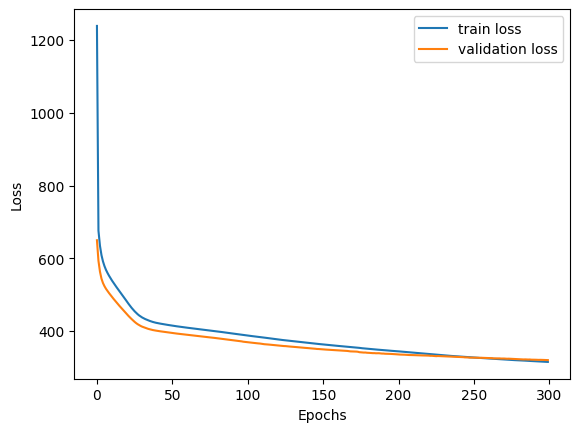

In [86]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=2)

model.fit(
    X_train_preprocessed, y_train, 
    epochs=300, batch_size=32, 
    validation_data=(X_eval_preprocessed, y_eval), 
    callbacks=[early_stop]
)

# Draw plot of loss
history = model.history.history
plt.plot(history['loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [87]:
y_pred = model.predict(X_test_preprocessed)

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [88]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

r2 = r2_score(y_test, y_pred)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"R² Score       : {r2:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

R² Score       : 0.7101
Mean Squared Error (MSE): 339.0030
Mean Absolute Error (MAE): 12.6368


In [89]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout
# from tensorflow.keras.optimizers import Adam
# from scikeras.wrappers import KerasRegressor  # for regression task

# def build_model(units=32, dropout_rate=0.2, learning_rate=0.001, num_layers=1):
#     model = Sequential()
#     model.add(Dense(units, activation='relu', input_shape=(n_components_95,)))
#     model.add(Dropout(dropout_rate))

#     for _ in range(num_layers - 1):
#         model.add(Dense(units, activation='relu'))
#         model.add(Dropout(dropout_rate))

#     model.add(Dense(1))  # output layer for regression

#     model.compile(optimizer=Adam(learning_rate=learning_rate),
#                   loss='mse', metrics=['mae'])
#     return model


In [90]:
# model = KerasRegressor(model=build_model, verbose=0)

In [91]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'model__units': [16, 32, 64],
#     'model__dropout_rate': [0.1, 0.3],
#     'model__learning_rate': [0.001, 0.01],
#     'model__num_layers': [1, 2,3],
#     'batch_size': [32],
#     'epochs': [50]  # You can increase this with Early Stopping
# }


In [92]:
# from sklearn.model_selection import GridSearchCV

# grid = GridSearchCV(estimator=model,
#                     param_grid=param_grid,
#                     scoring='neg_mean_squared_error',
#                     cv=3,
#                     verbose=1)

# grid_result = grid.fit(X_train_preprocessed, y_train,
#                        validation_data=(X_eval_preprocessed, y_eval),
#                        callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])


In [93]:
// y_pred = best_model.predict(X_test_preprocessed)

SyntaxError: invalid syntax (2072155176.py, line 1)

In [ ]:
# from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# r2 = r2_score(y_test, y_pred)

# mse = mean_squared_error(y_test, y_pred)
# mae = mean_absolute_error(y_test, y_pred)

# print(f"R² Score       : {r2:.4f}")
# print(f"Mean Squared Error (MSE): {mse:.4f}")
# print(f"Mean Absolute Error (MAE): {mae:.4f}")

In [ ]:
grid_result

,estimator,KerasRegresso...se epochs=1 )
,param_grid,"{'batch_size': [32], 'epochs': [50], 'model__dropout_rate': [0.1, 0.3], 'model__learning_rate': [0.001, 0.01], ...}"
,scoring,'neg_mean_squared_error'
,n_jobs,None
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,model,<function bui...x7f43e56bf380>


In [ ]:
// best_model = grid.best_estimator_

In [ ]:
// y_pred = best_model.predict(X_test_preprocessed)

2025-07-19 23:18:46.533967: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_18', 8 bytes spill stores, 8 bytes spill loads



In [ ]:
# from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# r2 = r2_score(y_test, y_pred)

# mse = mean_squared_error(y_test, y_pred)
# mae = mean_absolute_error(y_test, y_pred)

# print(f"R² Score       : {r2:.4f}")
# print(f"Mean Squared Error (MSE): {mse:.4f}")
# print(f"Mean Absolute Error (MAE): {mae:.4f}")

R² Score       : 0.2603
Mean Squared Error (MSE): 864.9373
Mean Absolute Error (MAE): 18.6786
